#  Data Exploration


## Data preparation

This notebook file is to compare the distance between different labeled data groups.

The data sources are
1. The original netcdf data set.
2. The last layer feature of NN model.

Set `dataset_type = 1` to use original netcdf data set

Set `dataset_type = 2` to use last layer feature of NN model

In [1]:
import sys
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
from docs.distance.calculate_distance import calculate
from docs.distance.data_nn import data_nn

dataset_type = 1
path_to_data = 'climex/data/small_trainingset/training_database_daily.nc'

s = time.time()
if dataset_type == 1:
    total_xr = xr.open_dataset(path_to_data, engine='netcdf4')
    input_label = total_xr.variables['labels'][:]
    input_data = total_xr.variables['mslp'][:]
else:
    input_label, input_data = data_nn(n_years_val=1, n_years_test=1, splitting_method='sequential', season=None,
            path_to_data=path_to_data,
            model_path="files/model-vit-20.pt")

label, data_index, distance = calculate(input_label, input_data)
e = time.time()
print("Pandas Loading Time = {}".format(e-s))

100%|██████████| 5558/5558 [08:09<00:00, 11.35it/s] 


Pandas Loading Time = 532.9300668239594


### Load data

Read the file into the pandas dataframe, extract the `label` and the corresponding `index of the label` in the original data set.

In [2]:
distance = pd.DataFrame(distance)
data = distance.iloc[:len(label)-1]

print('data: ',data)

num_0=label.count(0)
num_11=label.count(11)
num_17=label.count(17)
print('number of label 0: ',num_0,'number of label 11: ',num_11,'number of label 17: ',num_17)

data:        0        1        2        3        4        5        6        7     \
0      NaN  28996.0  49689.0  45734.0  29790.0  64585.0  79561.0  32783.0   
1      NaN      NaN  60672.0  49848.0  32342.0  66335.0  86821.0  40043.0   
2      NaN      NaN      NaN  69188.0  60535.0  86001.0  65785.0  64900.0   
3      NaN      NaN      NaN      NaN  63807.0  57350.0  96361.0  63309.0   
4      NaN      NaN      NaN      NaN      NaN  82971.0  78667.0  28652.0   
...    ...      ...      ...      ...      ...      ...      ...      ...   
5552   NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5553   NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5554   NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5555   NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5556   NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

         8         9     ...     5548     5549     5550     5551    

### Data grouping

Divide the data into six groups: `Label 0/11-0/17-0/11/17-11/17`.

`Label 11-0` represents the distance between each labeled 11 data minus each of labeled 0 data.

The distance used for calculation is the `Manhattan distance`:

`round(np.sum(abs(mslp[j] - mslp[i]))/10)`

In [3]:
def tolist(data):

    data_0=data.iloc[0:num_0,0:num_0]
    data_11_0=data.iloc[0:num_0,num_0:num_0+num_11]
    data_17_0=data.iloc[0:num_0,num_0+num_11:]

    data_11=data.iloc[num_0:num_0+num_11,num_0:num_0+num_11]
    data_17_11=data.iloc[num_0:num_0+num_11,num_0+num_11:]
    data_17=data.iloc[num_0+num_11:,num_0+num_11:]

    list=[data_0,data_11_0,data_17_0,data_11,data_17_11,data_17]

    for i in range(len(list)):
        list[i]=list[i].to_numpy()
        list[i]=np.reshape(list[i],-1)
        list[i]=list[i][~np.isnan(list[i])]

    return list,data_0.fillna(float("inf")),data_11_0.fillna(float("inf")),data_17_0.fillna(float("inf")),data_11.fillna(float("inf")),data_17_11.fillna(float("inf")),data_17.fillna(float("inf"))

list,data_0,data_11_0,data_17_0,data_11,data_17_11,data_17=tolist(data)

### Boxplot

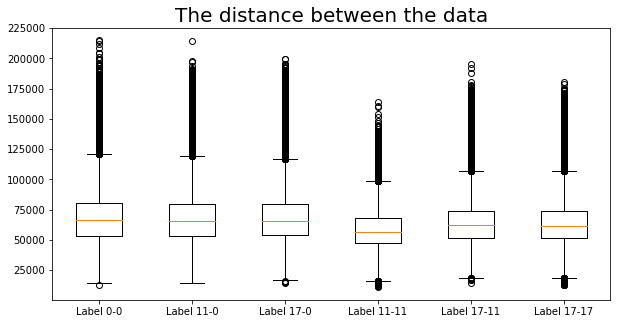

In [4]:
def boxplot(list):

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.title('The distance between the data',fontsize=20)
    labels = 'Label 0-0','Label 11-0','Label 17-0','Label 11-11','Label 17-11','Label 17-17'
    plt.boxplot(list, labels = labels)
    plt.show()

boxplot(list)

### Group overview

Descriptive statistics of those six groups of data.

In [5]:
def stat(list):
    print("Label 0/11-0/17-0/11/17-11/17")
    for i in range(len(list)):
        print (pd.DataFrame(list[i]).describe(include='all'))

stat(list)

Label 0/11-0/17-0/11/17-11/17
                  0
count  3.860031e+06
mean   6.823221e+04
std    2.004866e+04
min    1.299500e+04
25%    5.361700e+04
50%    6.620100e+04
75%    8.059200e+04
max    2.148660e+05
                  0
count  2.559459e+06
mean   6.779657e+04
std    1.978108e+04
min    1.472400e+04
25%    5.338600e+04
50%    6.537300e+04
75%    7.964900e+04
max    2.141300e+05
                  0
count  5.163382e+06
mean   6.781507e+04
std    1.897508e+04
min    1.444600e+04
25%    5.419100e+04
50%    6.591900e+04
75%    7.932400e+04
max    1.998120e+05
                   0
count  423660.000000
mean    58250.533001
std     15488.064626
min     10695.000000
25%     47162.000000
50%     56535.000000
75%     67708.000000
max    164173.000000
                  0
count  1.711218e+06
mean   6.359709e+04
std    1.676672e+04
min    1.476200e+04
25%    5.164600e+04
50%    6.200100e+04
75%    7.375700e+04
max    1.956350e+05
                  0
count  1.725153e+06
mean   6.343242e+04
s

### Percentage of data

Example: The proportion of labeled 11 data that is less than 0.25 Quantile of labeled 0 data.

In [6]:
def count(data,value):
    count=0
    for i in range(len(data)):
        if data[i]<value:
            count=count+1
    print(count/len(data))

print("Label 11-0/17-0: 0.25/0.50/0.75/1.0 Quantile")
for i in [1,2]:
    count(list[i],int(pd.DataFrame(list[0]).quantile(.25).values))
    count(list[i],int(pd.DataFrame(list[0]).quantile(.5).values))
    count(list[i],int(pd.DataFrame(list[0]).quantile(.75).values))
    count(list[i],int(pd.DataFrame(list[0]).quantile(1).values))

print("Label 17-11: 0.25/0.50/0.75/1.0 Quantile")
count(list[5],int(pd.DataFrame(list[4]).quantile(.25).values))
count(list[5],int(pd.DataFrame(list[4]).quantile(.5).values))
count(list[5],int(pd.DataFrame(list[4]).quantile(.75).values))
count(list[5],int(pd.DataFrame(list[4]).quantile(1).values))

Label 11-0/17-0: 0.25/0.50/0.75/1.0 Quantile
0.2545237098933798
0.5168244539178006
0.7629612351672755
1.0
0.23884636077671573
0.5060396461079192
0.7684908844629353
1.0
Label 17-11: 0.25/0.50/0.75/1.0 Quantile
0.25279786778332125
0.5030417591946917
0.7524642741832174
1.0


### Figure of data

The images with the minimum distance of the above 6 groups of data.

(Corresponding to the mslp data in the original data set)

[(1618, 2364), (2497, 3406), (1992, 4986), (2815, 3572), (3691, 5148), (4064, 5279)]
Label 0/11-0/17-0/11/17-11/17: Min Distance
12995.0
14724.0
14446.0
10695.0
14762.0
12561.0


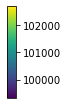

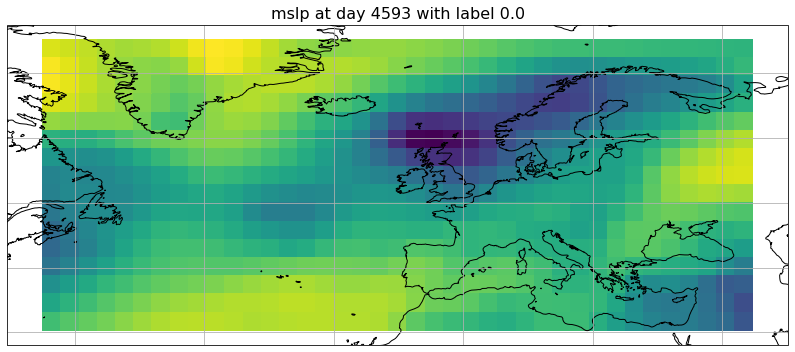

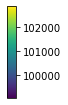

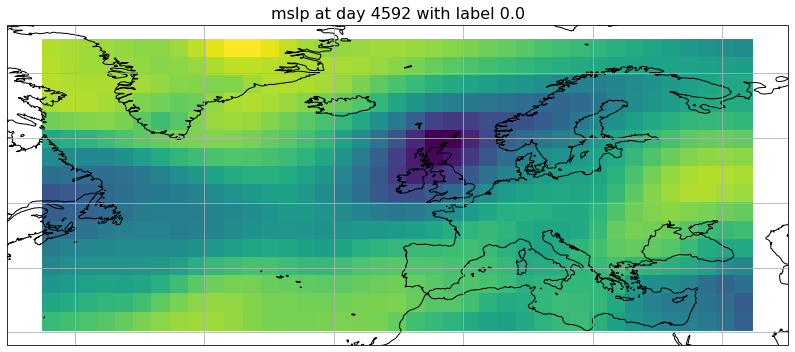

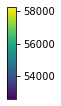

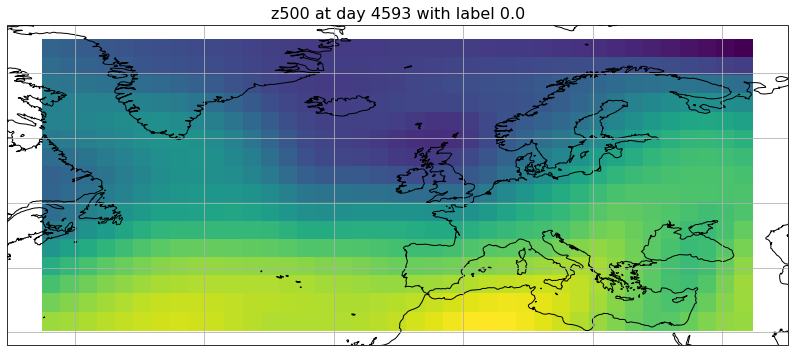

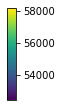

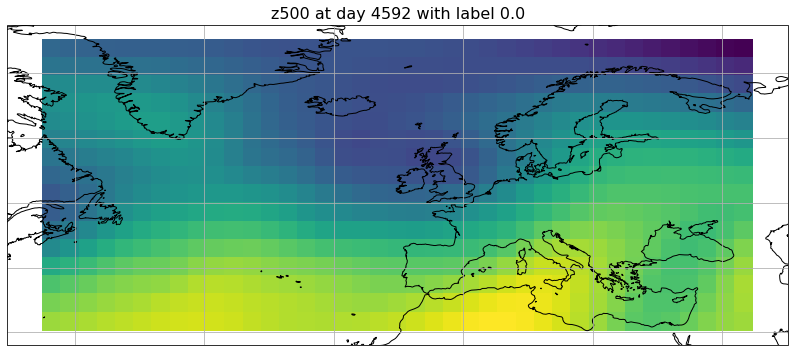

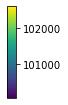

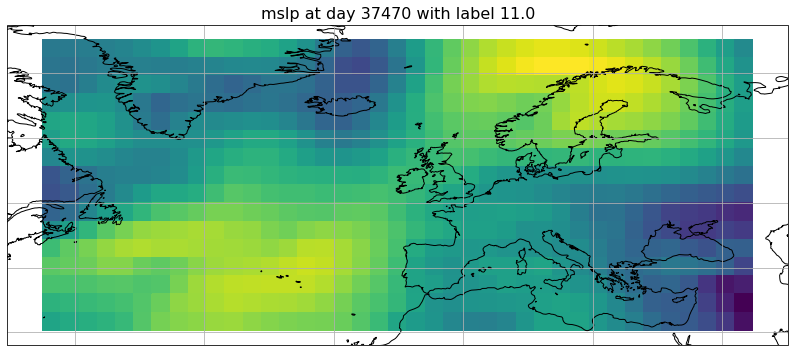

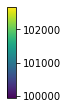

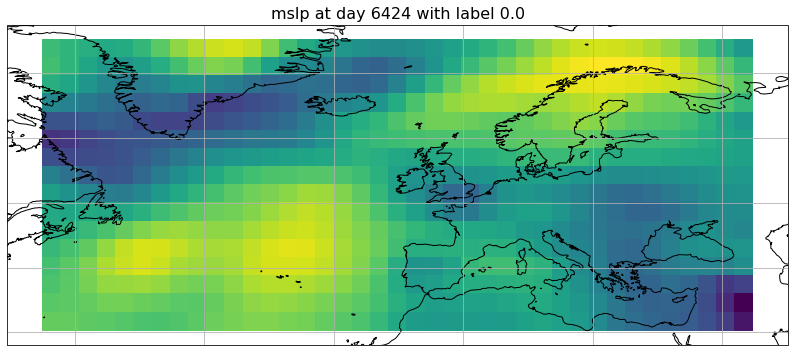

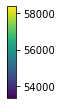

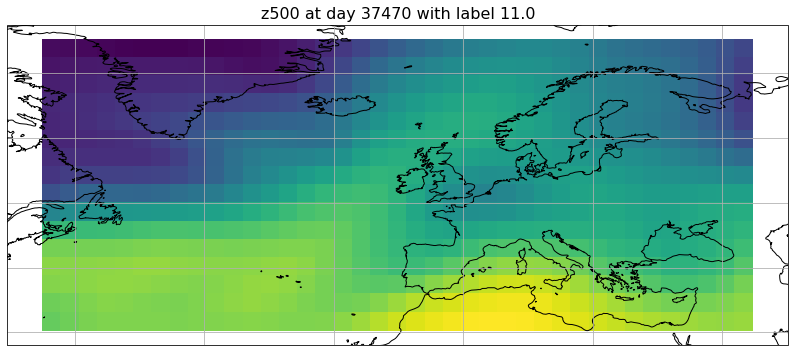

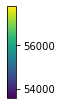

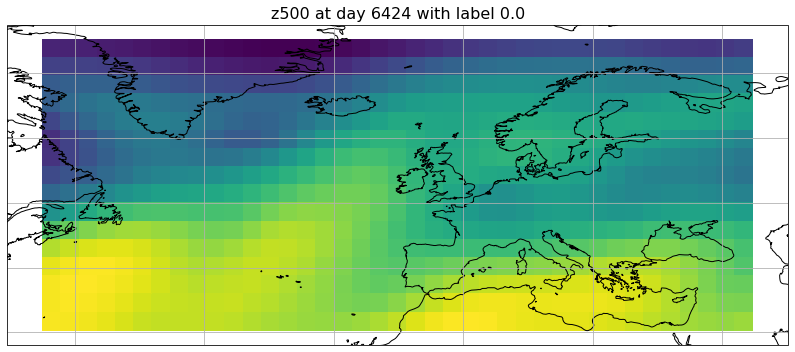

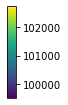

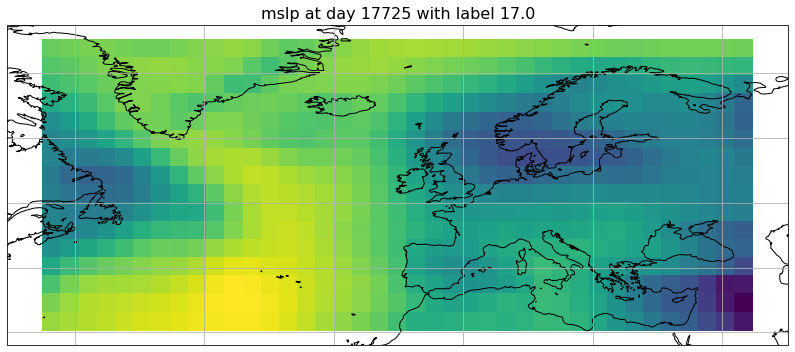

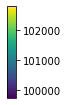

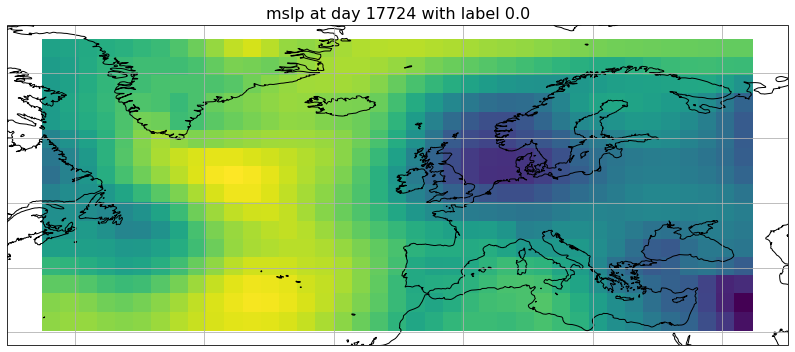

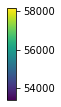

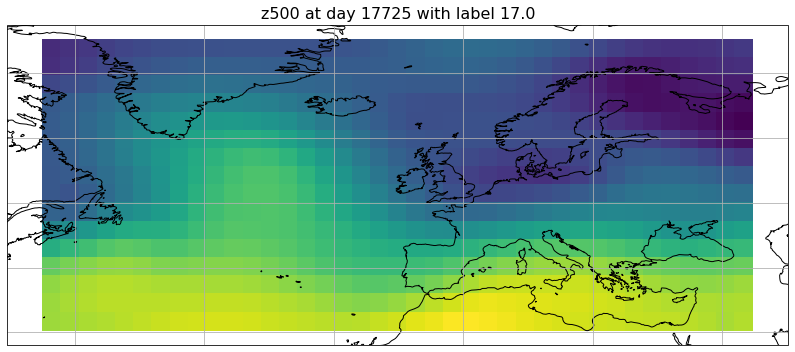

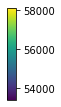

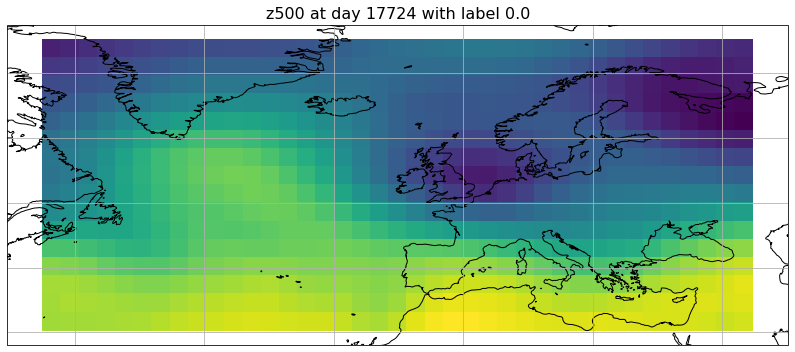

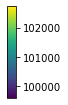

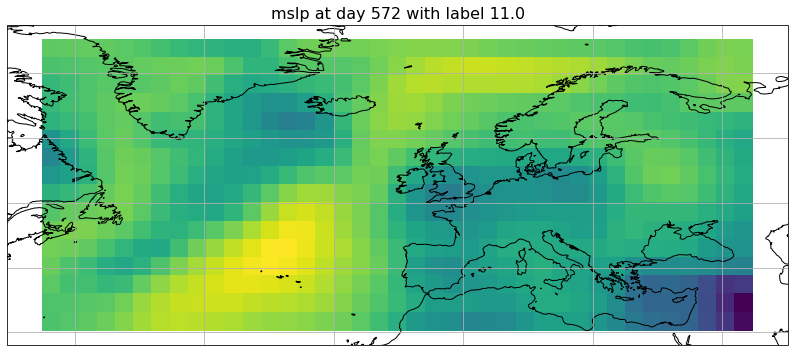

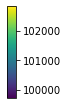

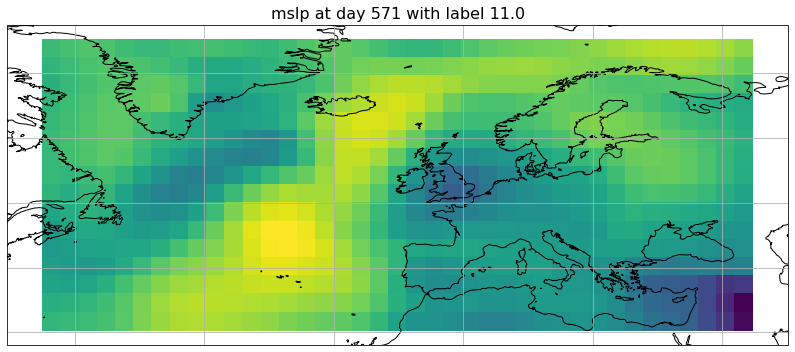

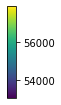

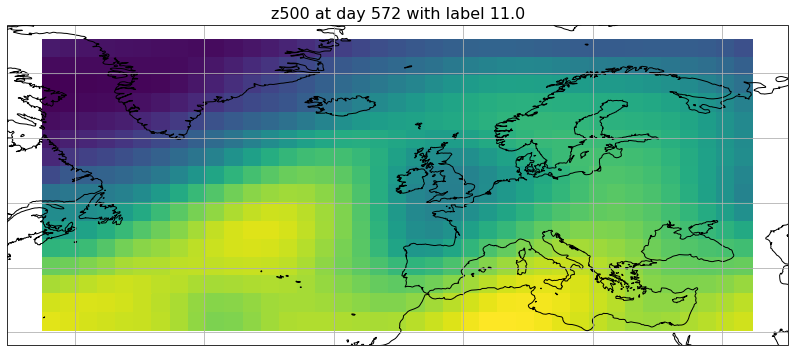

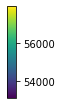

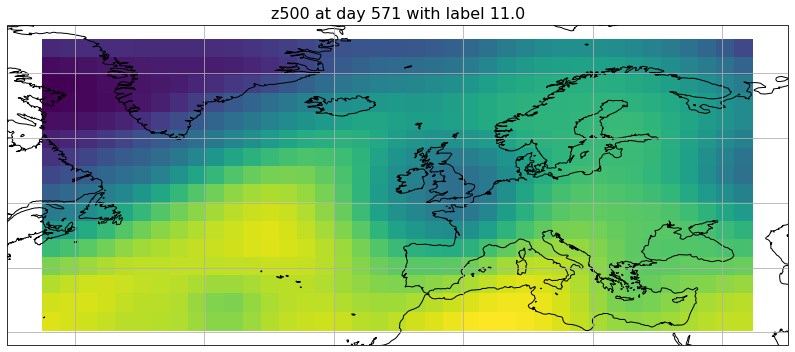

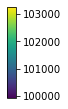

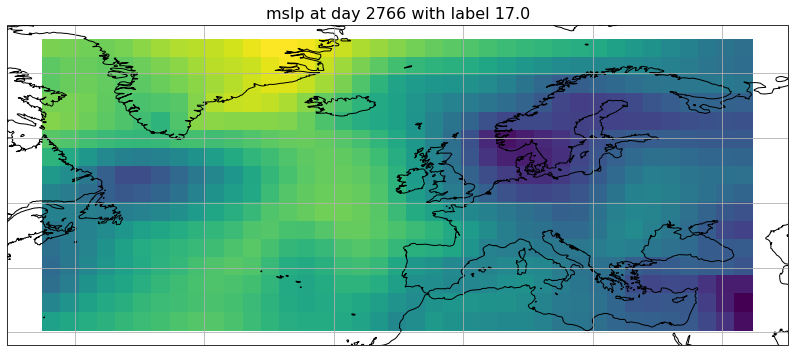

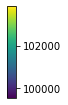

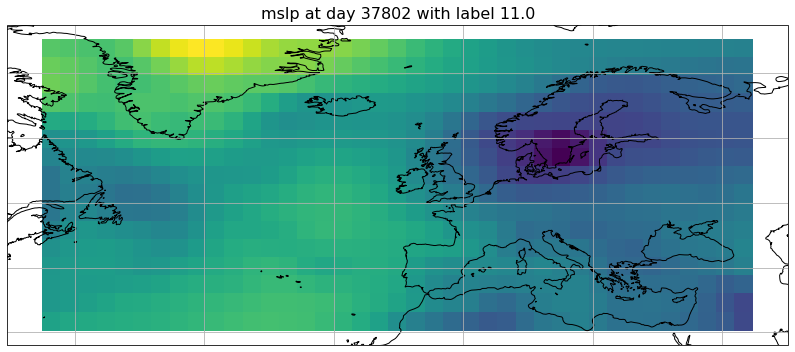

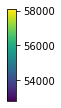

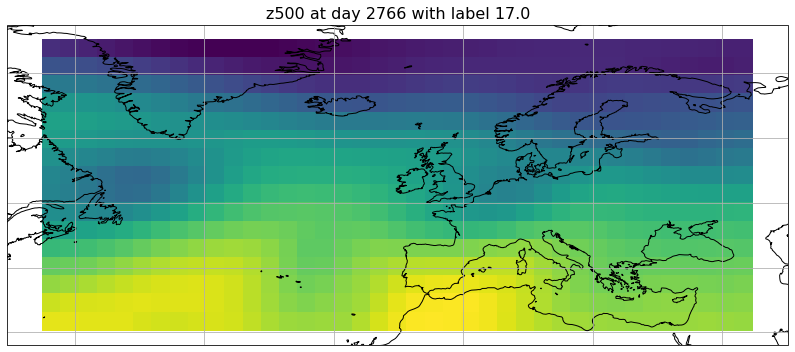

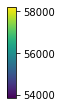

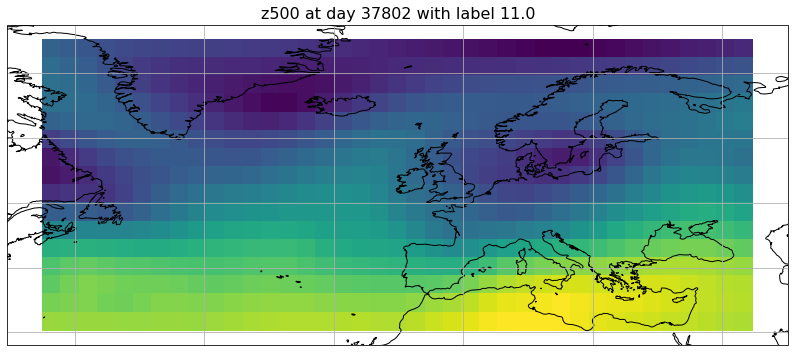

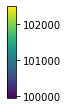

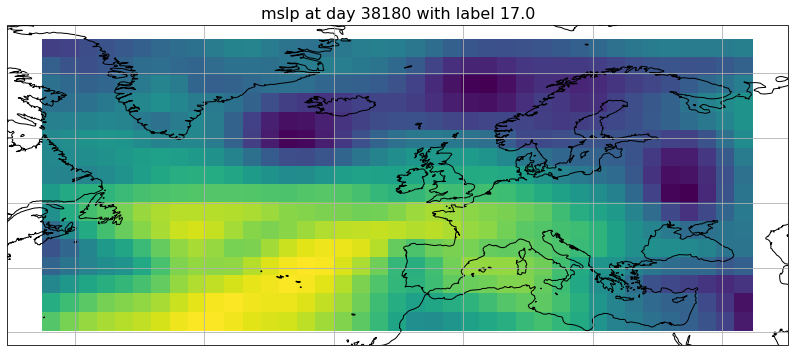

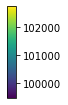

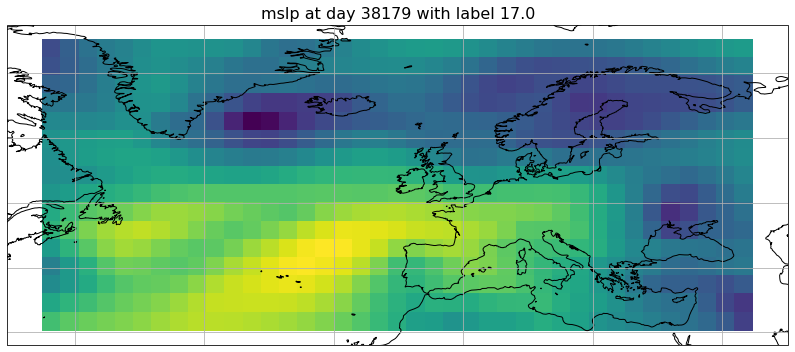

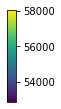

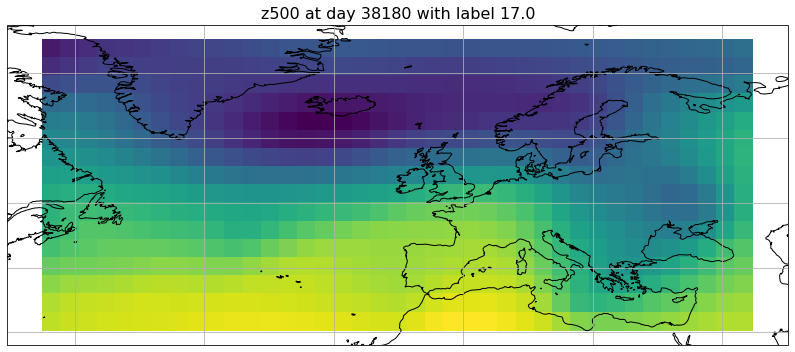

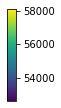

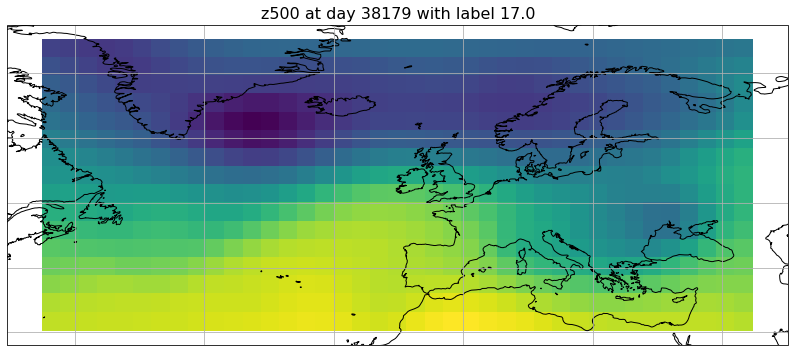

In [7]:
import netCDF4

dataset = netCDF4.Dataset(path_to_data)
data_label=dataset.variables['labels'][:]
data_mslp = dataset.variables['mslp'][:]

def plot_for_date(ds, index, var_name):

    var = ds.variables[var_name][index, :, :]
    lat = ds.variables['latitude'][:]
    lon = ds.variables['longitude'][:]
    label = str(dataset.variables['labels'][index])

    # Plot
    fig = plt.figure()
    plt.figure(figsize=(14, 14))
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    mm = ax.pcolormesh(lon, lat, var, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(mm, cax=cax)
    title = str(var_name)+" at day "+ str(index) + ' with label ' + label
    ax.set_title(title, fontsize=16)
    plt.show()


index=[data_0.stack().index[np.argmin(data_0.values)]]
index.append(data_11_0.stack().index[np.argmin(data_11_0.values)])
index.append(data_17_0.stack().index[np.argmin(data_17_0.values)])
index.append(data_11.stack().index[np.argmin(data_11.values)])
index.append(data_17_11.stack().index[np.argmin(data_17_11.values)])
index.append(data_17.stack().index[np.argmin(data_17.values)])
print(index)
print("Label 0/11-0/17-0/11/17-11/17: Min Distance")

for i in range(6):

    print(data.iloc[index[i][0],int(index[i][1])])
    # print(round(np.sum(abs(data_mslp[data_index[int(index[i][1])-2]] - data_mslp[data_index[index[i][0]]]))/10))
    plot_for_date(dataset, data_index[int(index[i][1])], 'mslp')
    plot_for_date(dataset, data_index[index[i][0]], 'mslp')
    plot_for_date(dataset, data_index[int(index[i][1])], 'z500')
    plot_for_date(dataset, data_index[index[i][0]], 'z500')